In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from datetime import datetime


In [18]:
keras.utils.set_random_seed(69)

In [19]:
df = pd.read_csv("../data/clean/2024-10-28_21-01-53.csv")
df.head()

,Task,Category
0,Finish Quarterly Report,urgent important
1,Schedule Meeting with Client X,urgent important
2,Respond to Urgent Email,urgent not-important
3,Clean Desk,not-urgent not-important
4,Learn New Programming Language,not-urgent important


# Create Dataset

In [20]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

['Finish Quarterly Report' 'Schedule Meeting with Client X'
 'Respond to Urgent Email' 'Clean Desk' 'Learn New Programming Language'
 'Pay Monthly Bills' 'Exercise Regularly' 'Read Book on Leadership'
 'Attend Networking Event' 'Plan Vacation']

['urgent important' 'urgent important' 'urgent not-important'
 'not-urgent not-important' 'not-urgent important' 'urgent not-important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'not-urgent important']


# Hyperparameters

In [21]:
EMBEDDING_DIM = 100
MAX_LENGTH = 64
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [22]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 9 batches for a total of 1152 elements for training.
There are 1 batches for a total of 128 elements for validation.


# Vectorize Dataset

In [23]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [24]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    lowercase=True,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

Vocabulary size = 230


In [25]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


In [26]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [35 34 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
The original string: update study schedule [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [27]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[ 47  34  56 ...   0   0   0]
 [  9 193  79 ...   0   0   0]
 [ 46  22 159 ...   0   0   0]
 ...
 [ 38   7  25 ...   0   0   0]
 [ 59 205  66 ...   0   0   0]
 [ 55  51  96 ...   0   0   0]]
Labels: [1 2 3 0 0 2 3 1 0 2 1 1 3 0 1 1 2 2 2 0 1 1 1 0 0 1 2 2 2 0 2 0 2 3 0 1 0
 0 1 2 1 3 1 2 2 1 2 1 0 2 1 0 2 0 0 0 0 0 0 1 1 0 2 2 2 0 2 0 1 2 2 1 1 1
 2 1 1 0 1 2 2 2 2 3 2 3 0 1 2 0 2 3 1 2 2 0 1 1 0 2 0 3 3 1 1 2 0 0 1 1 2
 1 0 1 0 0 2 0 0 1 2 0 0 0 1 1 3 0]


2024-10-29 00:08:44.542024: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Train

In [28]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 64, 100)        │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,466 (224.48 KB)

 Trainable params: 57,466 (224.48 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.3365 - loss: 1.3680 - val_accuracy: 0.3793 - val_loss: 1.3247
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4138 - loss: 1.3031 - val_accuracy: 0.3793 - val_loss: 1.2869
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4201 - loss: 1.2937 - val_accuracy: 0.3534 - val_loss: 1.3234
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4408 - loss: 1.2484 - val_accuracy: 0.3621 - val_loss: 1.2828
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4537 - loss: 1.2307 - val_accuracy: 0.6207 - val_loss: 1.1577
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4810 - loss: 1.2206 - val_accuracy: 0.4655 - val_loss: 1.1955
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4870 - loss: 1.1613 - val_accuracy: 0.6379 - val_loss: 1.0007
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5452 - loss: 1.0707 - val_accuracy: 0.5603 - val_loss

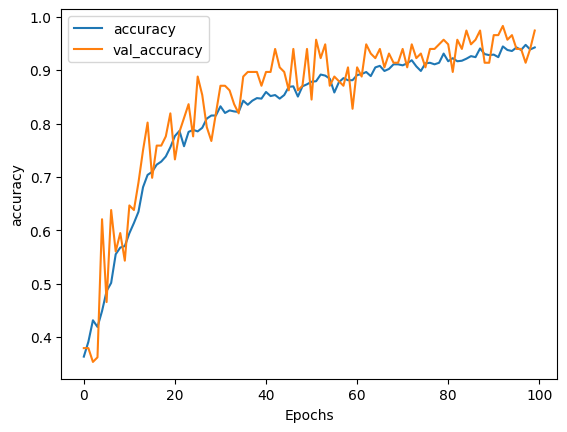

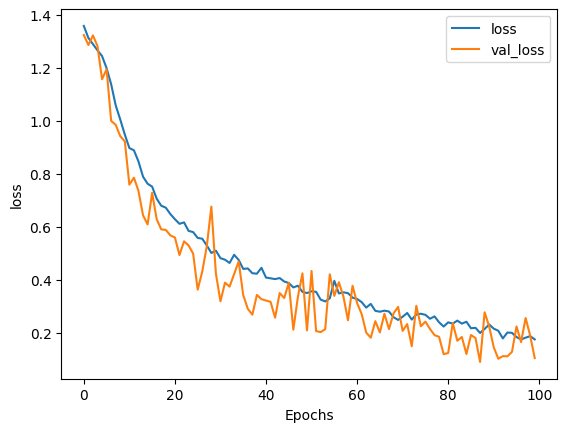

In [30]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [31]:
task = "Prepare an infrastructure for data migration to cloud which will help the developer team to update the company’s app due in 3 days"
print(f"Input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, len(task_vec)))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.5f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: Prepare an infrastructure for data migration to cloud which will help the developer team to update the company’s app due in 3 days
Vectorized input: prepare an infrastructure for data migration to cloud which will help the developer team to update the company [UNK] s app due in [UNK] days [PAD] [PAD] [PAD] [PAD]
	[54, 7, 79, 205, 186, 71, 113, 71, 225, 220, 45, 169, 36, 10, 111, 45, 111, 19, 222, 221, 71, 49, 51, 9, 190, 193, 225, 52, 29, 73, 138, 73, 29, 222, 191, 14, 40, 190, 96, 158, 101, 53, 44, 51, 35, 158, 151, 1, 25, 7, 96, 96, 10, 225, 40, 205, 1, 10, 75, 33, 0, 0, 0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Prediction vector: [9.9999785e-01 3.8465515e-08 1.6408291e-06 4.4545797e-07]
	not-urgent important: 99.99979%
	not-urgent not-important: 0.00000%
	urgent important: 0.00016%
	urgent not-important: 0.00004%
Prediction: not-urgent important


# Save

In [32]:
packed_model = keras.Sequential([
    tokenizer,
    label_lookup,
    model,
])

packed_model.built = True
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
packed_model.save(f"../model/{now}.keras")